-------------
# 1．ライブラリのインポート

In [ ]:
# 基本的なライブラリ
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from scipy import stats

# Scikit-learn関連
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils.validation import check_X_y
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.linear_model import Lasso

# 抽象基底クラス (ABC)
from abc import ABCMeta, abstractmethod

# タイピングのサポート
from typing import Optional

# 可視化の設定
import matplotlib.pyplot as plt
from matplotlib import cm
import japanize_matplotlib
import itertools
plt.style.use("ggplot")

--------
# 2．実験設定

In [ ]:
### 実験データの設定 ###
n = 100000  # データサイズ
p = 20  # 特徴量数
s = 5  # 非ゼロ係数の数
rho = 0.35  # 相関レベル
snr = 1  # 信号対雑音比
beta_type = "first_large"


### 実験設定 ###
N_CLUSTERS = 10
K_MIN = 2
K_MAX = 10


### シード ###
RANDOM_STATE = 0  # 乱数シード

-----------
# 3．データの前処理

### データ作成

In [ ]:
def simulate_data(n, p, rho, snr, beta, seed):
    np.random.seed(seed)

    # 共分散行列Σの生成
    Sigma = np.fromfunction(lambda i, j: rho ** np.abs(i - j), (p, p), dtype=int)

    # Xの生成 (多変量正規分布)
    X = np.random.multivariate_normal(mean=np.zeros(p), cov=Sigma, size=n)

    # 応答変数Yの生成
    signal_variance = beta.T @ Sigma @ beta  # β₀の分散
    noise_variance = signal_variance / snr  # ノイズ分散 σ²
    noise = np.random.normal(scale=np.sqrt(noise_variance), size=n)  # ノイズ項
    Y = X @ beta + noise

    return X, Y, beta


In [4]:
X_train, y_train, beta_train = simulate_data(n, p, s, rho, snr, beta_type, seed=0)
X_test, y_test, beta_test = simulate_data(n, p, s, rho, snr, beta_type, seed=1)

### 標準化

In [ ]:
sc = StandardScaler()
sc.fit(X_train) # 訓練データに基づいてfit
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

-------------
# 4．Kmeansのクラスタサイズ確認

In [6]:
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE)
labels = kmeans.fit_predict(X_test_std)
cluster_size = np.bincount(labels)

print(cluster_size)

[ 9611  9812 10439 10490  9669 10443 10226  9669  9858  9783]


----------------
# 5．シルエット係数で確認

In [ ]:
def silhouette(X, k_min=2, k_max=10):
    kmeans = KMeans(n_clusters=k_min, random_state=RANDOM_STATE)
    kmeans.fit(X)
    labels = kmeans.predict(X)
    best_score = silhouette_score(X, labels)
    score_dict = {}
    score_dict[k_min] = best_score
    best_k = k_min
    for k in range(k_min + 1, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
        kmeans.fit(X)
        labels = kmeans.predict(X)
        current_score = silhouette_score(X, labels)
        score_dict[k] = current_score
        if current_score > best_score:
            best_score = current_score
            best_k = k
    return best_k, score_dict

In [ ]:
best_k, score_dict = silhouette(X_train_std, k_min=K_MIN, k_max=K_MAX)
print("n_clusters chosen in Xmeans:", best_k)

x = []
for k in score_dict.keys():
    x.append(str(k))
y = [score for score in score_dict.values()]
bars = plt.bar(x, y)
plt.ylabel("Silhouette score", fontsize=30)
plt.xlabel("Number of clusters", fontsize=30)
plt.tick_params(axis="both", which="major", labelsize=25)
plt.tight_layout()
plt.show()

-------------
# 6．Xmeans で確認

In [7]:
# def compute_bic(X, kmeans):
#     labels = kmeans.labels_
#     clusters = kmeans.cluster_centers_
#     n_clusters = len(clusters)
#     n = len(X)
#     m = X.shape[1]
#     variance = np.sum(
#         [
#             np.linalg.norm(X[labels == i] - clusters[i], axis=1).sum()
#             for i in range(n_clusters)
#         ]
#     )
#     bic = np.log(n) * n_clusters * m + n * np.log(variance / n)
#     return bic


# def xmeans(X, k_min=2, k_max=10):
#     kmeans = KMeans(n_clusters=k_min, random_state=RANDOM_STATE)
#     kmeans.fit(X)
#     best_bic = compute_bic(X, kmeans)
#     best_k = k_min
#     score_dict = {}
#     score_dict[k_min] = best_bic
#     for k in range(k_min + 1, k_max + 1):
#         kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
#         kmeans.fit(X)
#         current_bic = compute_bic(X, kmeans)
#         score_dict[k] = current_bic
#         if current_bic < best_bic:
#             best_bic = current_bic
#             best_k = k
#     return best_k, score_dict

In [8]:
# best_k, score_dict = xmeans(X_train_std, k_min=K_MIN, k_max=K_MAX)
# print("n_clusters chosen in Xmeans:", best_k)

# x = []
# for k in score_dict.keys():
#     x.append(str(k))
# y = [score for score in score_dict.values()]
# bars = plt.bar(x, y)
# plt.ylabel("BIC", fontsize=30)
# plt.xlabel("Number of clusters", fontsize=30)
# plt.tick_params(axis="both", which="major", labelsize=25)
# plt.tight_layout()
# plt.show()

-----
# 7．エルボー図で確認

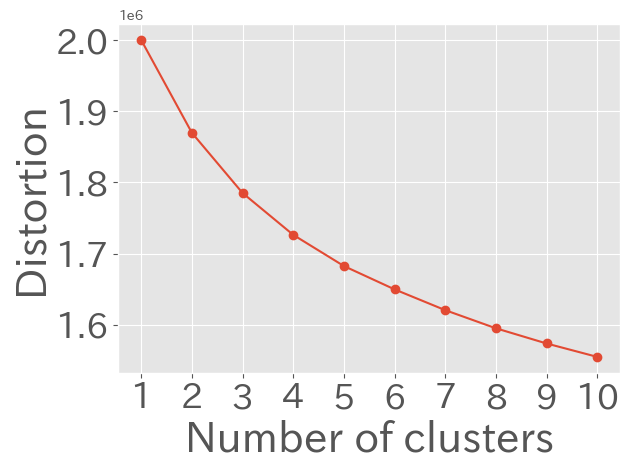

In [14]:
distortions = []
for i in range(K_MIN - 1, K_MAX + 1):
    kmeans = KMeans(n_clusters=i, random_state=RANDOM_STATE)
    kmeans.fit(X_train_std)
    distortions.append(kmeans.inertia_)

plt.plot(range(K_MIN - 1, K_MAX + 1), distortions, marker="o")
plt.xlabel("Number of clusters", fontsize=30)
plt.ylabel("Distortion", fontsize=30)
plt.xticks(range(K_MIN - 1, K_MAX + 1))
plt.tick_params(axis="both", labelsize=25)
plt.tight_layout()
plt.show()